In [132]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.structural import UnobservedComponents
import matplotlib.pyplot as plt

In [133]:
# 1. Đọc dữ liệu
df = pd.read_csv('D:/timesr/thucHanh1/train.csv')

In [134]:
df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,6,Criminal Minds,Episode 47,69.83,True Crime,35.82,Sunday,Night,39.02,0.0,Neutral,64.75024
1,16,Study Sessions,Episode 82,78.47,Education,48.84,Sunday,Afternoon,NaN,2.0,Neutral,42.89441
2,18,Digital Digest,Episode 72,7.34,Technology,20.81,Sunday,Night,83.06,3.0,Positive,0.75783
3,42,Innovators,Episode 17,32.29,Technology,89.36,Sunday,Evening,42.61,3.0,Neutral,26.57501
4,46,Mind & Body,Episode 2,92.81,Health,28.52,Sunday,Evening,24.65,0.0,Positive,53.58589


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115946 entries, 0 to 115945
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           115946 non-null  int64  
 1   Podcast_Name                 115946 non-null  object 
 2   Episode_Title                115946 non-null  object 
 3   Episode_Length_minutes       102794 non-null  float64
 4   Genre                        115946 non-null  object 
 5   Host_Popularity_percentage   115946 non-null  float64
 6   Publication_Day              115946 non-null  object 
 7   Publication_Time             115946 non-null  object 
 8   Guest_Popularity_percentage  93523 non-null   float64
 9   Number_of_Ads                115946 non-null  float64
 10  Episode_Sentiment            115946 non-null  object 
 11  Listening_Time_minutes       115946 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 10.6+ MB


In [136]:
df.isna().sum()

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         13152
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    22423
Number_of_Ads                      0
Episode_Sentiment                  0
Listening_Time_minutes             0
dtype: int64

In [137]:
df = df.drop(columns='id')

In [138]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Listening_Time_minutes']

In [139]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['Podcast_Name',
 'Episode_Title',
 'Genre',
 'Publication_Day',
 'Publication_Time',
 'Episode_Sentiment']

In [140]:
# 2. Xử lý missing
# 2.1 Numeric: điền median
num_cols = df.select_dtypes(include=[np.number]).columns
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

In [141]:
# 2.2 Categorical: điền 'Unknown'
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna('Unknown')

In [142]:
df.isnull().sum().sum() 

np.int64(0)

In [143]:
# 3. Tạo biến giả cho Publication_Day
day_dummies = pd.get_dummies(df['Publication_Day'], prefix='weekday')
df = pd.concat([df.drop(columns=['Publication_Day']), day_dummies], axis=1)

In [144]:
# 4. Chia train/test (80/20)
n = len(df)
train = df.iloc[:int(0.8 * n)].copy()
test  = df.iloc[int(0.8 * n):].copy()

In [145]:
# 5. Target
y_train = train['Listening_Time_minutes']
y_test  = test['Listening_Time_minutes']
steps = len(y_test)

In [146]:
# 6. Khởi tạo & fit 3 mô hình Kalman
models = {
    'LocalLevel':         UnobservedComponents(y_train, level='local level'),
    'LocalLinearTrend':   UnobservedComponents(y_train, level='local linear trend'),
    'Level+WeeklySeason': UnobservedComponents(y_train, level='local level', seasonal=7)
}
fitted = {name: mdl.fit(disp=False) for name, mdl in models.items()}

In [147]:
# 7. Forecast
forecasts = {
    name: res.get_forecast(steps=steps).predicted_mean
    for name, res in fitted.items()
}

In [148]:
# 8. Đánh giá
print("=== Performance ===")
for name, y_pred in forecasts.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    print(f"{name:20s} → RMSE = {rmse:.4f}, MAE = {mae:.4f}")

=== Performance ===
LocalLevel           → RMSE = 26.7536, MAE = 22.1281
LocalLinearTrend     → RMSE = 27.2535, MAE = 22.2275
Level+WeeklySeason   → RMSE = 26.7552, MAE = 22.1293


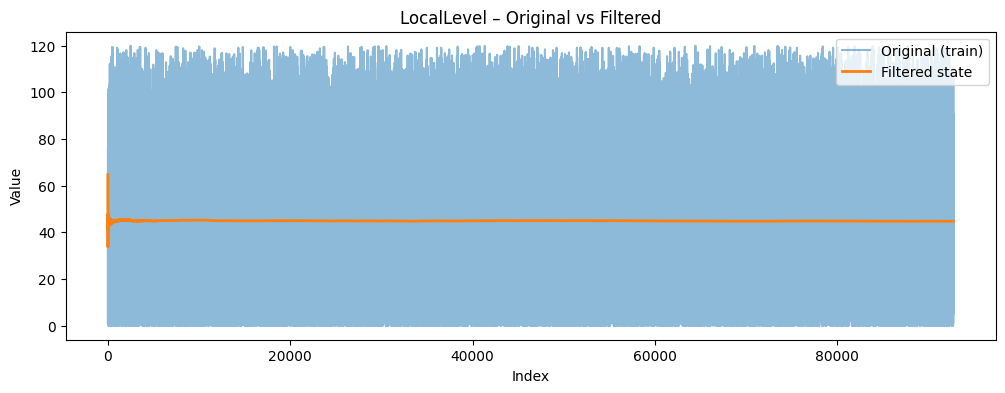

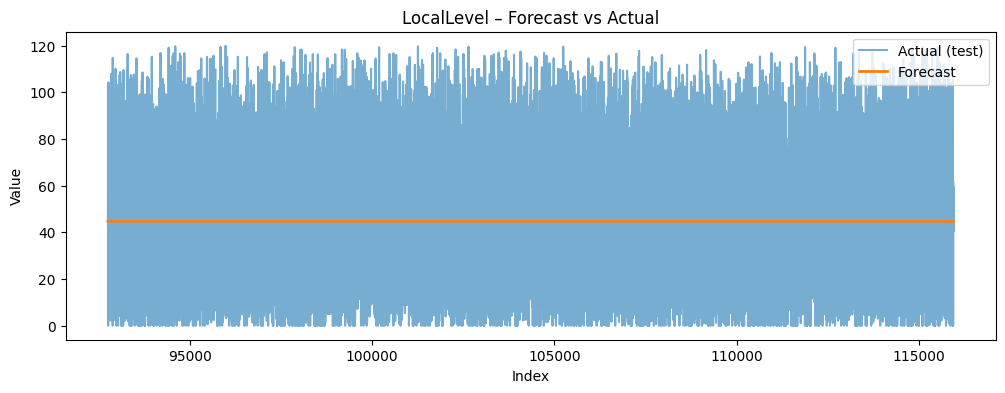

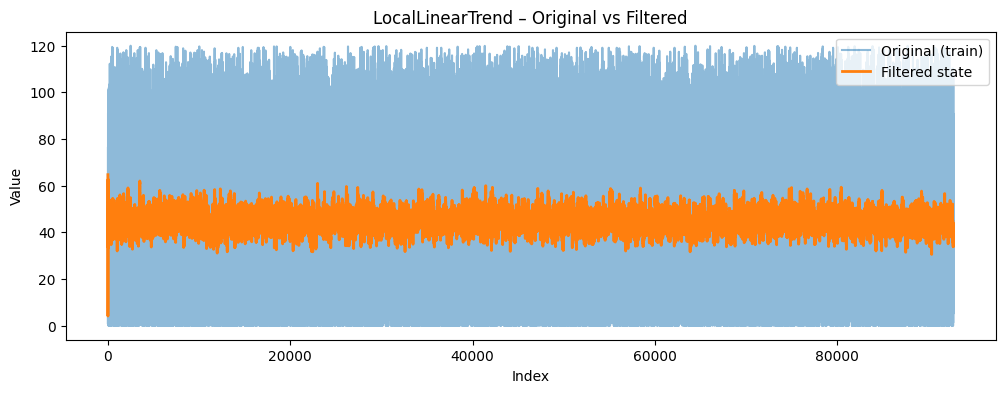

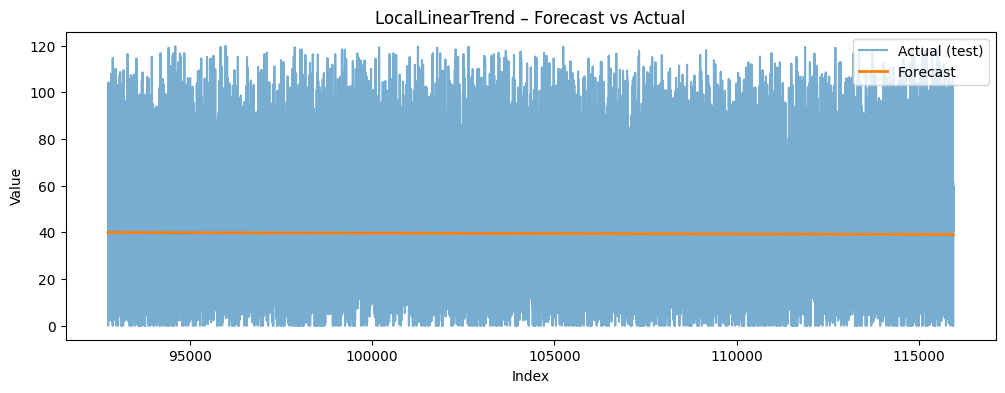

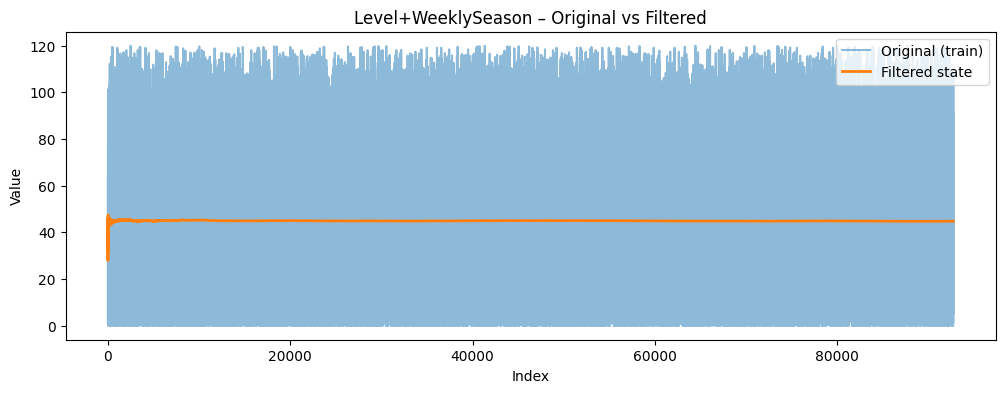

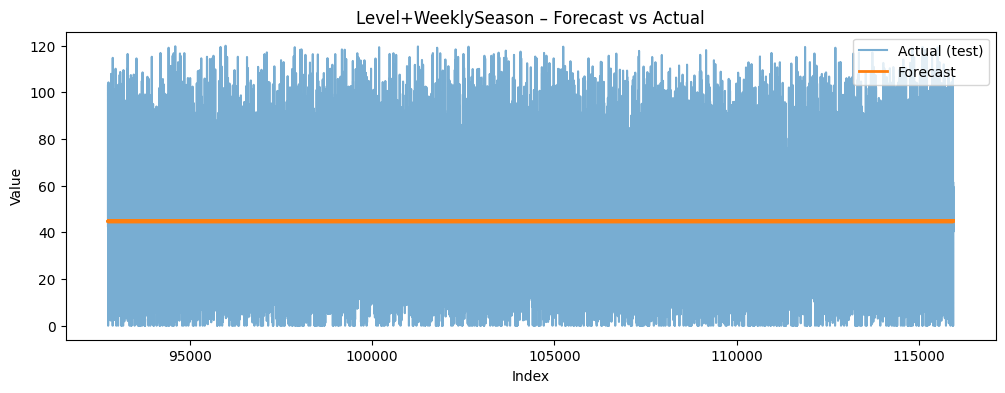

In [149]:
# 9. Trực quan hóa
for name, result in fitted.items():
    filtered = result.filtered_state[0]

    # 9.1 Original vs Filtered
    plt.figure(figsize=(12,4))
    plt.plot(y_train.index, y_train, label='Original (train)', alpha=0.5)
    plt.plot(y_train.index, filtered, label='Filtered state', linewidth=2)
    plt.title(f'{name} – Original vs Filtered')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # 9.2 Forecast vs Actual
    y_pred = forecasts[name]
    plt.figure(figsize=(12,4))
    plt.plot(y_test.index, y_test, label='Actual (test)', alpha=0.6)
    plt.plot(y_test.index, y_pred, label='Forecast', linewidth=2)
    plt.title(f'{name} – Forecast vs Actual')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()